<a href="https://colab.research.google.com/github/mm9494/Functions-/blob/main/Copy_of_HW1_DS_UA_202_Mina_Mohammadi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Responsible Data Science Spring 2021: Homework 1


This notebook contains sample code; other methods at arriving at the correct answer were also accepted.

In [35]:
!pip install aif360==0.3.0 
!pip install BlackBoxAuditing
!pip install tensorflow==1.12.0
import matplotlib.pyplot as plt 

import random
random.seed(6)

import sys
import warnings

import numpy as np
import pandas as pd
import tensorflow as tf

from tqdm import tqdm

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score, mean_squared_error, explained_variance_score
from math import sqrt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

from aif360.algorithms.preprocessing import DisparateImpactRemover
from aif360.algorithms.inprocessing import AdversarialDebiasing
from aif360.algorithms.inprocessing.meta_fair_classifier import MetaFairClassifier
import BlackBoxAuditing
from aif360.algorithms.preprocessing import Reweighing
from aif360.datasets import CompasDataset, AdultDataset, StandardDataset, BankDataset, GermanDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.postprocessing import EqOddsPostprocessing
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult


from aif360.algorithms.inprocessing import GerryFairClassifier
from aif360.algorithms.inprocessing import PrejudiceRemover

from sklearn.preprocessing import MinMaxScaler
from aif360.metrics import BinaryLabelDatasetMetric

from aif360.algorithms.postprocessing.reject_option_classification import RejectOptionClassification
import seaborn as sns

%matplotlib inline

ERROR: Could not find a version that satisfies the requirement tensorflow==1.12.0 (from versions: 1.13.0rc1, 1.13.0rc2, 1.13.1, 1.13.2, 1.14.0rc0, 1.14.0rc1, 1.14.0, 1.15.0rc0, 1.15.0rc1, 1.15.0rc2, 1.15.0rc3, 1.15.0, 1.15.2, 1.15.3, 1.15.4, 1.15.5, 2.0.0a0, 2.0.0b0, 2.0.0b1, 2.0.0rc0, 2.0.0rc1, 2.0.0rc2, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.1.0rc0, 2.1.0rc1, 2.1.0rc2, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.2.0rc0, 2.2.0rc1, 2.2.0rc2, 2.2.0rc3, 2.2.0rc4, 2.2.0, 2.2.1, 2.2.2, 2.3.0rc0, 2.3.0rc1, 2.3.0rc2, 2.3.0, 2.3.1, 2.3.2, 2.4.0rc0, 2.4.0rc1, 2.4.0rc2, 2.4.0rc3, 2.4.0rc4, 2.4.0, 2.4.1)
ERROR: No matching distribution found for tensorflow==1.12.0


# Problem 2
### **Load and split data into train, validation and test sets** 

### Read in the data

In [36]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test
!wget	https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names

--2021-03-07 18:26:28--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3974305 (3.8M) [application/x-httpd-php]
Saving to: ‘adult.data.4’

adult.data.4        100%[===================>]   3.79M  9.23MB/s    in 0.4s    

2021-03-07 18:26:29 (9.23 MB/s) - ‘adult.data.4’ saved [3974305/3974305]

--2021-03-07 18:26:29--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2003153 (1.9M) [application/x-httpd-php]
Saving to: ‘adult.test.4’

adult.test.4        100%[===================>]   1.91M  5.14MB/s    in 0.4s    

In [37]:
!cp adult.data /usr/local/lib/python3.7/dist-packages/aif360/data/raw/adult/
!cp adult.test /usr/local/lib/python3.7/dist-packages/aif360/data/raw/adult/
!cp adult.names /usr/local/lib/python3.7/dist-packages/aif360/data/raw/adult/

In [38]:
# loading dataset 
dataset_orig = AdultDataset(protected_attribute_names=['sex'],
                            privileged_classes=[['Male']],
                            features_to_drop = ['race', 'age'])

# creating privlidged and unpriviledged groups 
privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]

# splitting original data into train and test data 
train_orig, test_orig = dataset_orig.split([0.7], shuffle=True, seed=10)
# splitting data again into training and validation data for hypterparameter tuning 
train_orig, val_orig = train_orig.split([1/3], shuffle=True)

# converting into dataframes 
train_orig_df, _ = train_orig.convert_to_dataframe()
val_orig_df, _ = val_orig.convert_to_dataframe()
test_orig_df, _ = test_orig.convert_to_dataframe()

test_orig_df.head()



,fnlwgt,education-num,sex,capital-gain,capital-loss,hours-per-week,workclass=Federal-gov,workclass=Local-gov,workclass=Private,workclass=Self-emp-inc,workclass=Self-emp-not-inc,workclass=State-gov,workclass=Without-pay,education=10th,education=11th,education=12th,education=1st-4th,education=5th-6th,education=7th-8th,education=9th,education=Assoc-acdm,education=Assoc-voc,education=Bachelors,education=Doctorate,education=HS-grad,education=Masters,education=Preschool,education=Prof-school,education=Some-college,marital-status=Divorced,marital-status=Married-AF-spouse,marital-status=Married-civ-spouse,marital-status=Married-spouse-absent,marital-status=Never-married,marital-status=Separated,marital-status=Widowed,occupation=Adm-clerical,occupation=Armed-Forces,occupation=Craft-repair,occupation=Exec-managerial,...,native-country=China,native-country=Columbia,native-country=Cuba,native-country=Dominican-Republic,native-country=Ecuador,native-country=El-Salvador,native-country=England,native-country=France,native-country=Germany,native-country=Greece,native-country=Guatemala,native-country=Haiti,native-country=Holand-Netherlands,native-country=Honduras,native-country=Hong,native-country=Hungary,native-country=India,native-country=Iran,native-country=Ireland,native-country=Italy,native-country=Jamaica,native-country=Japan,native-country=Laos,native-country=Mexico,native-country=Nicaragua,native-country=Outlying-US(Guam-USVI-etc),native-country=Peru,native-country=Philippines,native-country=Poland,native-country=Portugal,native-country=Puerto-Rico,native-country=Scotland,native-country=South,native-country=Taiwan,native-country=Thailand,native-country=Trinadad&Tobago,native-country=United-States,native-country=Vietnam,native-country=Yugoslavia,income-per-year
43919,159662.0,6.0,1.0,0.0,0.0,40.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
13331,184303.0,4.0,0.0,0.0,0.0,40.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22970,151835.0,9.0,1.0,0.0,0.0,60.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
773,127875.0,7.0,0.0,0.0,0.0,8.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
40503,203735.0,9.0,0.0,0.0,0.0,40.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [39]:
#MinMaxScalar on Feature columns 

Min_Max_Scaler = MinMaxScaler()
train_scaler = Min_Max_Scaler.fit_transform(train_orig_df)
print(train_scaler)


val_scaler = Min_Max_Scaler.transform(val_orig_df)
print(val_scaler)

test_scaler = Min_Max_Scaler.transform(test_orig_df)
print(test_scaler)

#seperate feature columns and outcome which is the income per year 
x_train = train_orig_df.drop("income-per-year", axis=1)
y_train = train_orig_df["income-per-year"]
x_val = val_orig_df.drop("income-per-year", axis=1)
y_val = val_orig_df["income-per-year"]
x_test = test_orig_df.drop("income-per-year", axis=1)
y_test = test_orig_df["income-per-year"]

#printing and making sure we can see the outcomes 
print("Outcomes: ")
y_train.value_counts()

[[0.12444666 0.73333333 0.         ... 0.         0.         1.        ]
 [0.20740219 0.86666667 1.         ... 0.         0.         1.        ]
 [0.13294075 0.4        0.         ... 0.         0.         0.        ]
 ...
 [0.1856383  0.8        1.         ... 0.         0.         1.        ]
 [0.14251369 0.73333333 1.         ... 0.         0.         1.        ]
 [0.17124066 0.4        1.         ... 0.         0.         0.        ]]
[[0.15857525 0.8        1.         ... 0.         0.         0.        ]
 [0.13291625 0.33333333 1.         ... 0.         0.         1.        ]
 [0.04963625 0.6        0.         ... 0.         0.         0.        ]
 ...
 [0.13115878 0.6        1.         ... 0.         0.         1.        ]
 [0.12279536 0.6        0.         ... 0.         0.         0.        ]
 [0.11687845 0.86666667 1.         ... 0.         0.         0.        ]]
[[0.10421601 0.33333333 1.         ... 0.         0.         0.        ]
 [0.12251173 0.2        0.         ... 

0.0    7937
1.0    2614
Name: income-per-year, dtype: int64

# Problem 2, Part (a) 
### **Train a baseline Logistic Regression (LR) & Random Forest (RF) model and report metrics**

In [40]:
# Set up the logistic regression model with the given hyperparameters
initial_lr = LogisticRegression(class_weight='balanced', solver='liblinear')
    
# Fit the model using the training data
initial_lr = initial_lr.fit(x_train, y_train, sample_weight=None)



In [41]:
def evaluate(model, X, y_true):
    '''Calculates the AUC and accuracy for a trained logistic regression model'''
    
    # Calculate predicted values
    y_pred = model.predict_proba(X)
    y_pred = [row[1] for row in y_pred] 

    # Calculate accuracy
    accuracy = accuracy_score(y_true, [pred_prob >= 0.5 for pred_prob in y_pred])
    
    # Calculate AUC
    auc = roc_auc_score(y_true, y_pred)

    #calc RMSE
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    
    #calc avergage precision 
    average_precision = average_precision_score(y_true, y_pred)

    #calc explained var
    exp_var = explained_variance_score(y_true, y_pred)

    return accuracy, auc, average_precision, rmse, exp_var

accuracy, auc, average_precision, rmse, exp_var = evaluate(initial_lr, x_test, y_test)
print("Accuracy: ", accuracy)
print("AUC: ", auc)
print("Average Precision", average_precision)
print("rmse:", rmse)
print("exp_var", exp_var)

Accuracy:  0.8017247733470922
AUC:  0.8982743218083894
Average Precision 0.7567895318032374
rmse: 0.36361039072561097
exp_var 0.37968224702097075


In [42]:

# Set up the random forest model with the given hyperparameters
initial_rf = RandomForestClassifier(n_estimators=10, max_depth = 3)


initial_rf = initial_rf.fit(x_train, y_train)

accuracy, auc, average_precision, rmse, exp_var = evaluate(initial_rf, x_test, y_test)
print("Accuracy: ", accuracy)
print("AUC: ", auc)
print("Average Precision", average_precision)
print("rmse:", rmse)
print("exp_var:", exp_var)


Accuracy:  0.7911844917815287
AUC:  0.8673772388440433
Average Precision 0.6786154971731467
rmse: 0.36724072748928305
exp_var: 0.2791915333282222


# Problem 2, Part (b)
### **Hyperparameter tuning of baseline LR and RF models**

In [ ]:
# function for boxplots
def plot_init_v_tuned_box(init_metrics, tuned_metrics, metric_name):
  '''Creates a bar graph comparing init_metrics to tuned_metrics'''

  # Make some x values
  x_init = list(range(len(init_metrics)))
  x_tuned = [x + 0.35 for x in x_init]

  # Plot the metrics
  plt.boxplot([init_metrics, tuned_metrics], labels=['Initial Model', 'Tuned Model'])

  # Create labels, etc. 
  plt.ylabel(metric_name)
  plt.legend()
  plt.show()


In [71]:
#logistic regression hyperparameter tuning 
def tune_logistic_regression(train_df, val_df, penalty_types, C_values, weights=None, verbose=True):
    '''Tunes logistic regression models over the hyperparameters penalty type and C
       to maximize the AUC'''

    # Pre-process the training and validation data
    x_train = train_df.drop("income-per-year", axis=1)
    y_train = train_df["income-per-year"]
    x_val = val_df.drop("income-per-year", axis=1)
    y_val = val_df["income-per-year"]

    # Create empty lists where we will store the results of hyperparameter tuning 
    parameters = []
    models = []
    val_aucs = []
    rmse = []
    exp_var = []


    # Loop through the hyperparameters of interest
    for penalty in penalty_types:
        for C in C_values:
            
            # Train the logistic regression model with the given hyperparameters
            lr = LogisticRegression(C=C, penalty=penalty, solver='liblinear')
    
            # Fit the model using the training data
            lr = lr.fit(x_train, y_train, sample_weight=weights)
            
            # Get the evalution metrics on the validation set 
            accuracy, auc, average_precision, rmse, exp_var = evaluate(lr, x_test, y_test)
            
            # Store the results
            parameters.append({'penalty': penalty, 'C': C})
            models.append(lr)
            val_aucs.append(auc)
            exp_var.append(explained_variance_score)
            rmse.append(rmse)
            
            # Print the results
            if verbose:
                print("\nParameters: \tpenalty={} \tC={}".format(penalty, C))
                print("Validation AUC: {}".format(auc))
            
    
    # Determine the best model -- that is, the one with the highest AUC
    best_model_index = np.argmax(val_aucs)
    best_model = models[best_model_index]
    
    print("\nBest model parameters: ", parameters[best_model_index])
    print("Best model AUC: ", val_aucs[best_model_index])
    
    # Return best model
    return best_model, parameters, models, val_aucs, rmse, exp_var


In [72]:
#determining the best model for linear regression
best_model, parameters, models, val_aucs, rmse, exp_var = tune_logistic_regression(train_orig_df, val_orig_df, penalty_types=["l1", "l2"], C_values=[0.001, 0.1, 1, 10, 100, 1000, 10000, 100000])

# Training logistic regression 
best_lr = best_model.fit(x_train, y_train, sample_weight=None)

accuracy, avg_precision, auc, dis_impact, mean_diff = evaluate(best_lr, x_test, y_test)
print("Best tuned logistic regression model metrics")
print("Accuracy: ", accuracy)
print("Average Precision: ", avg_precision)
print("AUC: ", auc)
print("RMSE: ", rmse)
print("Explained variance", exp_var)

initial_lr_metrics = evaluate(initial_lr, x_test, y_test)
tuned_lr_metrics = evaluate(best_lr, x_test, y_test)
for m in models:
  plot_init_v_tuned_box(initial_lr_metrics, tuned_lr_metrics, "accuracy")
  plot_init_v_tuned_box(initial_lr_metrics, tuned_lr_metrics, "avg_precision")
  plot_init_v_tuned_box(initial_lr_metrics, tuned_lr_metrics, "auc")
  plot_init_v_tuned_box(initial_lr_metrics, tuned_lr_metrics, "rmse")
  plot_init_v_tuned_box(initial_lr_metrics, tuned_lr_metrics, "exp_var")



AttributeError: ignored

In [ ]:
#random forest hyperparameter tuning 
def tune_random_forest(train_df, val_df, penalty_types, C_values, weights=None, verbose=True):
    '''Tunes logistic regression models over the hyperparameters penalty type and C
       to maximize the AUC'''
    # Pre-process the training and validation data
    x_train = train_df.drop("income-per-year", axis=1)
    y_train = train_df["income-per-year"]
    x_val = val_df.drop("income-per-year", axis=1)
    y_val = val_df["income-per-year"]

    # Create empty lists where we will store the results of hyperparameter tuning 
    parameters = []
    models = []
    val_aucs = []
    
    # Loop through the hyperparameters of interest
    for penalty in penalty_types:
        for C in C_values:
            
            # Train the logistic regression model with the given hyperparameters
            rf = RandomForestClassifier(C=C, penalty=penalty, solver='liblinear')
    
            # Fit the model using the training data
            rf = rf.fit(x_train, y_train, sample_weight=weights)
            
            # Get the evalution metrics on the validation set 
            accuracy, auc  = evaluate(lr, x_val, y_val)
            
            # Store the results
            parameters.append({'penalty': penalty, 'C': C})
            models.append(lr)
            val_aucs.append(auc)
            
            # Print the results
            if verbose:
                print("\nParameters: \tpenalty={} \tC={}".format(penalty, C))
                print("Validation AUC: {}".format(auc))
            
    
    # Determine the best model -- that is, the one with the highest AUC
    best_model_index = np.argmax(val_aucs)
    best_model = models[best_model_index]
    
    print("\nBest model parameters: ", parameters[best_model_index])
    print("Best model AUC: ", val_aucs[best_model_index])
    
    # Return best model
    return best_model, parameters, models, val_aucs

In [50]:
#training the model random forest  

best_model, parameters, models, val_aucs = tune_logistic_regression(train_orig_df, val_orig_df, penalty_types=["l1", "l2"], C_values=[0.001, 0.1, 1, 10, 100, 1000, 10000, 100000])





Parameters: 	penalty=l1 	C=0.001
Validation AUC: 0.5991255490235945

Parameters: 	penalty=l1 	C=0.1
Validation AUC: 0.8987921379292803

Parameters: 	penalty=l1 	C=1
Validation AUC: 0.8999194688930814

Parameters: 	penalty=l1 	C=10
Validation AUC: 0.8987577000938417

Parameters: 	penalty=l1 	C=100
Validation AUC: 0.8970662971306894

Parameters: 	penalty=l1 	C=1000
Validation AUC: 0.8959261027932801

Parameters: 	penalty=l1 	C=10000
Validation AUC: 0.8955586690920659

Parameters: 	penalty=l1 	C=100000
Validation AUC: 0.8955439763899311

Parameters: 	penalty=l2 	C=0.001
Validation AUC: 0.5967512402992595

Parameters: 	penalty=l2 	C=0.1
Validation AUC: 0.6135499351227186

Parameters: 	penalty=l2 	C=1
Validation AUC: 0.6135501674184045

Parameters: 	penalty=l2 	C=10
Validation AUC: 0.5933305701761492

Parameters: 	penalty=l2 	C=100
Validation AUC: 0.6135501964553653

Parameters: 	penalty=l2 	C=1000
Validation AUC: 0.6135499351227187

Parameters: 	penalty=l2 	C=10000
Validation AUC: 0.61354

In [73]:
# function for boxplots
def plot_init_v_tuned_box(init_metrics, tuned_metrics, metric_name):
  '''Creates a bar graph comparing init_metrics to tuned_metrics'''

  # Make some x values
  x_init = list(range(len(init_metrics)))
  x_tuned = [x + 0.35 for x in x_init]

  # Plot the metrics
  plt.boxplot([init_metrics, tuned_metrics], labels=['Initial Model', 'Tuned Model'])

  # Create labels, etc. 
  plt.ylabel(metric_name)
  plt.legend()
  plt.show()

print(plot_init_v_tuned_box)

  

<function plot_init_v_tuned_box at 0x7f18c0a2b5f0>


# Problem 2, Part (c) 
### **Disparate Impact Pre-Processing intervention**

In [57]:
def plot_repair_levels(repair_levels, metric_vals, metric_name, x_label='Repair level'):
  '''Takes a list of repair levels and another list of values of a metric and
  creates a line plot showing how the metric changed for different values of repair level'''

  # Plot the metrics
  plt.plot(repair_levels, metric_vals, color='#0384fc', linewidth=3, label=metric_name)

  # Create labels, etc. 
  plt.xlabel(x_label)
  plt.ylabel(metric_name)
  plt.legend()
  plt.show()


protected = 'sex'
dataset_orig = AdultDataset(protected_attribute_names=['sex'],
                            privileged_classes=[['Male']],
                            features_to_drop = ['race', 'age'])
scaler = MinMaxScaler(copy=False)

test, train = dataset_orig.split([16281])
train.features = scaler.fit_transform(train.features)
test.features = scaler.fit_transform(test.features)

index = train.feature_names.index(protected)

DIs = []
for level in tqdm(np.linspace(0., 1., 11)):
    di = DisparateImpactRemover(repair_level=level)
    train_repd = di.fit_transform(train)
    test_repd = di.fit_transform(test)
    
    X_tr = np.delete(train_repd.features, index, axis=1)
    X_te = np.delete(test_repd.features, index, axis=1)
    y_tr = train_repd.labels.ravel()
    
    lmod = LogisticRegression(class_weight='balanced', solver='liblinear')
    lmod.fit(X_tr, y_tr)
    
    test_repd_pred = test_repd.copy()
    test_repd_pred.labels = lmod.predict(X_te)

    p = [{protected: 1}]
    u = [{protected: 0}]
    cm = BinaryLabelDatasetMetric(test_repd_pred, privileged_groups=p, unprivileged_groups=u)
    DIs.append(cm.disparate_impact())



100%|██████████| 11/11 [04:27<00:00, 24.35s/it]


ValueError: ignored

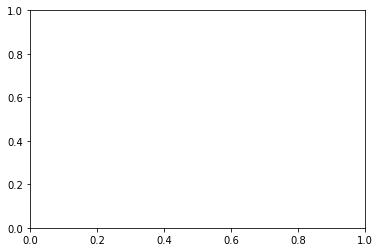

In [58]:
for repair_level in [0.2, 0.4, 0.6, 0.8, 1]:
    plot_repair_levels(repair_level, DIs, "Disparate Impact", x_label='Repair level')